# Bitcoin Next-Day Price Direction Prediction - Data Preparation
This notebook prepares data for predicting whether Bitcoin price will go up or down "tomorrow" using 2024 data and a focused set of features

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ------------------------------
# 1. Load Data from CSV Files
# ------------------------------
BTC_FILE = 'btc_data.csv'  # Update with your Bitcoin CSV file path
NASDAQ_FILE = 'nasdaq_data.csv'  # Update with your NASDAQ CSV file path
GLD_FILE = 'gld_data.csv'      # Update with your GLD CSV file path

# Load each file
try:
    # Load Bitcoin data
    btc_data = pd.read_csv(BTC_FILE, index_col=0, parse_dates=True)
    print(f"Bitcoin data loaded with {len(btc_data)} rows")
    
    # Load NASDAQ data
    nasdaq_data = pd.read_csv(NASDAQ_FILE, index_col=0, parse_dates=True)
    print(f"NASDAQ data loaded with {len(nasdaq_data)} rows")
    
    # Load GLD data
    gld_data = pd.read_csv(GLD_FILE, index_col=0, parse_dates=True)
    print(f"GLD data loaded with {len(gld_data)} rows")
    
    # Check the date ranges
    print(f"\nDate ranges:")
    print(f"Bitcoin: {btc_data.index.min()} to {btc_data.index.max()}")
    print(f"NASDAQ: {nasdaq_data.index.min()} to {nasdaq_data.index.max()}")
    print(f"GLD: {gld_data.index.min()} to {gld_data.index.max()}")
    
    # Create combined DataFrame with MultiIndex columns (similar to yfinance output)
    # Align all dates
    all_dates = sorted(set(btc_data.index) | set(nasdaq_data.index) | set(gld_data.index))
    idx = pd.DatetimeIndex(all_dates)
    
    # Identify common columns across all datasets
    expected_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Check which columns are available in each dataset
    btc_cols = [col for col in expected_cols if col in btc_data.columns]
    nasdaq_cols = [col for col in expected_cols if col in nasdaq_data.columns]
    gld_cols = [col for col in expected_cols if col in gld_data.columns]
    
    # Create MultiIndex columns
    columns = []
    for ticker, cols in [('BTC-USD', btc_cols), ('^IXIC', nasdaq_cols), ('GLD', gld_cols)]:
        for col in cols:
            columns.append((ticker, col))
    
    # Create DataFrame with MultiIndex columns
    data = pd.DataFrame(index=idx, columns=pd.MultiIndex.from_tuples(columns))
    
    # Fill with data
    for col in btc_cols:
        data[('BTC-USD', col)] = btc_data[col]
    
    for col in nasdaq_cols:
        data[('^IXIC', col)] = nasdaq_data[col]
    
    for col in gld_cols:
        data[('GLD', col)] = gld_data[col]
    
    print(f"\nCombined DataFrame created with shape: {data.shape}")
except Exception as e:
    print(f"Error loading CSV data: {e}")
    raise

Bitcoin data loaded with 522 rows
NASDAQ data loaded with 522 rows
GLD data loaded with 522 rows

Date ranges:
Bitcoin: 2023-01-02 00:00:00 to 2024-12-31 00:00:00
NASDAQ: 2023-01-02 00:00:00 to 2024-12-31 00:00:00
GLD: 2023-01-02 00:00:00 to 2024-12-31 00:00:00

Combined DataFrame created with shape: (522, 15)


In [5]:
# ------------------------------
# 1.2. Prepare Data Structure
# ------------------------------
# Extract data for each asset for easier processing
btc = pd.DataFrame()
nasdaq = pd.DataFrame()
gld = pd.DataFrame()

for col in btc_cols:
    btc[col] = data[('BTC-USD', col)]

for col in nasdaq_cols:
    nasdaq[col] = data[('^IXIC', col)]

for col in gld_cols:
    gld[col] = data[('GLD', col)]

# Check for missing values
missing_nasdaq = nasdaq['Close'].isna().sum()
missing_gld = gld['Close'].isna().sum()
print(f"\nMissing values in Nasdaq: {missing_nasdaq}")
print(f"Missing values in GLD: {missing_gld}")

# Use BTC-USD as the base DataFrame and add columns for Nasdaq and GLD
df = btc.copy()

# Handle missing values using interpolation
df['Nasdaq'] = nasdaq['Close'].reindex(df.index).interpolate(method='linear')
df['GLD'] = gld['Close'].reindex(df.index).interpolate(method='linear')

# Filter only weekdays
df = df[df.index.weekday < 5]
print(f"After filtering for weekdays: {df.shape} rows")


Missing values in Nasdaq: 20
Missing values in GLD: 20
After filtering for weekdays: (522, 7) rows


In [6]:
# Si hay pocos valores faltantes, consideramos usar interpolación
df['Nasdaq'] = nasdaq['Close'].reindex(df.index).interpolate(method='linear')
df['GLD'] = gld['Close'].reindex(df.index).interpolate(method='linear')

In [7]:
# ------------------------------
# 3. Calculate Key Technical Indicators (Focused Set)
# ------------------------------
# We'll focus on indicators most relevant for next-day prediction

# ----- PRICE-BASED INDICATORS -----
# Short-term moving averages (more relevant for next-day prediction)
df['SMA5'] = df['Close'].rolling(window=5).mean()
df['SMA10'] = df['Close'].rolling(window=10).mean()
df['SMA20'] = df['Close'].rolling(window=20).mean()

# Price relative to moving averages
df['Close_to_SMA5'] = df['Close'] / df['SMA5']
df['Close_to_SMA10'] = df['Close'] / df['SMA10']
df['Close_to_SMA20'] = df['Close'] / df['SMA20']

# Bollinger Bands (20-day commonly used, but focusing on width as volatility indicator)
df['std20'] = df['Close'].rolling(window=20).std()
df['Upper_BB'] = df['SMA20'] + (df['std20'] * 2)
df['Lower_BB'] = df['SMA20'] - (df['std20'] * 2)
df['BB_width'] = (df['Upper_BB'] - df['Lower_BB']) / df['SMA20']
df['BB_pct'] = (df['Close'] - df['Lower_BB']) / (df['Upper_BB'] - df['Lower_BB'])

# Distance from recent high/low
df['dist_from_10d_high'] = df['Close'] / df['High'].rolling(10).max()
df['dist_from_10d_low'] = df['Close'] / df['Low'].rolling(10).min()

# ----- MOMENTUM INDICATORS -----
# RSI (both 14-day standard and 7-day shorter-term)
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# 14-day RSI (standard)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI14'] = 100 - (100 / (1 + rs))

# 7-day RSI (more reactive)
avg_gain7 = gain.rolling(window=7).mean()
avg_loss7 = loss.rolling(window=7).mean()
rs7 = avg_gain7 / avg_loss7
df['RSI7'] = 100 - (100 / (1 + rs7))

# MACD (12-26-9 standard)
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_hist'] = df['MACD'] - df['MACD_signal']
df['MACD_hist_change'] = df['MACD_hist'].diff()

# Rate of Change (various short timeframes)
for period in [1, 3, 5]:
    df[f'ROC_{period}d'] = (df['Close'] / df['Close'].shift(period) - 1) * 100

# ----- VOLATILITY INDICATORS -----
# ATR (Average True Range)
df['prev_close'] = df['Close'].shift(1)
df['tr'] = df.apply(lambda row: max(row['High'] - row['Low'],
                                    abs(row['High'] - row['prev_close']),
                                    abs(row['Low'] - row['prev_close'])), axis=1)
df['ATR14'] = df['tr'].rolling(window=14).mean()
df['ATR7'] = df['tr'].rolling(window=7).mean()
df['ATR_pct'] = df['ATR14'] / df['Close']  # Normalized ATR
df.drop(['prev_close', 'tr'], axis=1, inplace=True)

# High-Low Range
df['high_low_range'] = (df['High'] - df['Low']) / df['Close']
df['high_low_range_5d'] = df['high_low_range'].rolling(5).mean()

# ----- VOLUME INDICATORS -----
# Volume changes rather than absolute volume
df['volume_change_1d'] = df['Volume'].pct_change()
df['volume_change_3d'] = df['Volume'].pct_change(periods=3)
df['volume_ratio_to_MA5'] = df['Volume'] / df['Volume'].rolling(5).mean()

# ----- MARKET CONTEXT INDICATORS -----
# Returns for each asset
df['BTC_return'] = df['Close'].pct_change()
df['Nasdaq_return'] = df['Nasdaq'].pct_change()
df['GLD_return'] = df['GLD'].pct_change()

# Relative performance
df['BTC_vs_Nasdaq'] = df['BTC_return'] - df['Nasdaq_return']
df['BTC_vs_GLD'] = df['BTC_return'] - df['GLD_return']

# Recent correlations (short windows more relevant for next-day prediction)
for window in [5, 10]:
    df[f'BTC_Nasdaq_corr_{window}d'] = df['BTC_return'].rolling(window).corr(df['Nasdaq_return'])
    df[f'BTC_GLD_corr_{window}d'] = df['BTC_return'].rolling(window).corr(df['GLD_return'])

# Simple beta (market sensitivity)
nasdaq_var_10d = df['Nasdaq_return'].rolling(10).var()
btc_nasdaq_cov_10d = df['BTC_return'].rolling(10).cov(df['Nasdaq_return'])
df['BTC_Nasdaq_beta_10d'] = btc_nasdaq_cov_10d / nasdaq_var_10d

# ----- TEMPORAL FEATURES -----
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# Cyclical encoding of day of week
df['day_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 5))  # 5 days in trading week
df['day_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 5))

In [8]:
# ------------------------------
# 4. Create Target Variable
# ------------------------------
# Next-day price direction (1 = up, 0 = down)
df['target_nextday'] = (df['Close'].shift(-1) > df['Close']).astype(int)

Características basadas en retornos relativos

In [9]:
# ------------------------------
# 5. Filter 2024 Data for Analysis and Modeling
# ------------------------------
df_2024 = df.loc['2024-01-01':'2024-12-31'].copy()

# Check class balance
up_days = df_2024['target_nextday'].sum()
total_days = df_2024['target_nextday'].count()
up_days_pct = (up_days / total_days) * 100

print(f"\nClass Distribution for Next-Day Prediction:")
print(f"Up days: {up_days} ({up_days_pct:.2f}%)")
print(f"Down days: {total_days - up_days} ({100 - up_days_pct:.2f}%)")

# Check if dataset is significantly imbalanced
is_imbalanced = min(up_days_pct, 100 - up_days_pct) < 30
print(f"Dataset is {'imbalanced' if is_imbalanced else 'relatively balanced'}")


Class Distribution for Next-Day Prediction:
Up days: 131 (50.00%)
Down days: 131 (50.00%)
Dataset is relatively balanced


The dataset is very well balanced


ANOVA test for day-of-week effect in 2024:
F=1.6056, p=0.1733
Statistically significant difference between days: False
Day 0: Mean return = 1.2531%
Day 1: Mean return = -0.3821%
Day 2: Mean return = 0.5504%
Day 3: Mean return = 0.0640%
Day 4: Mean return = 0.3357%


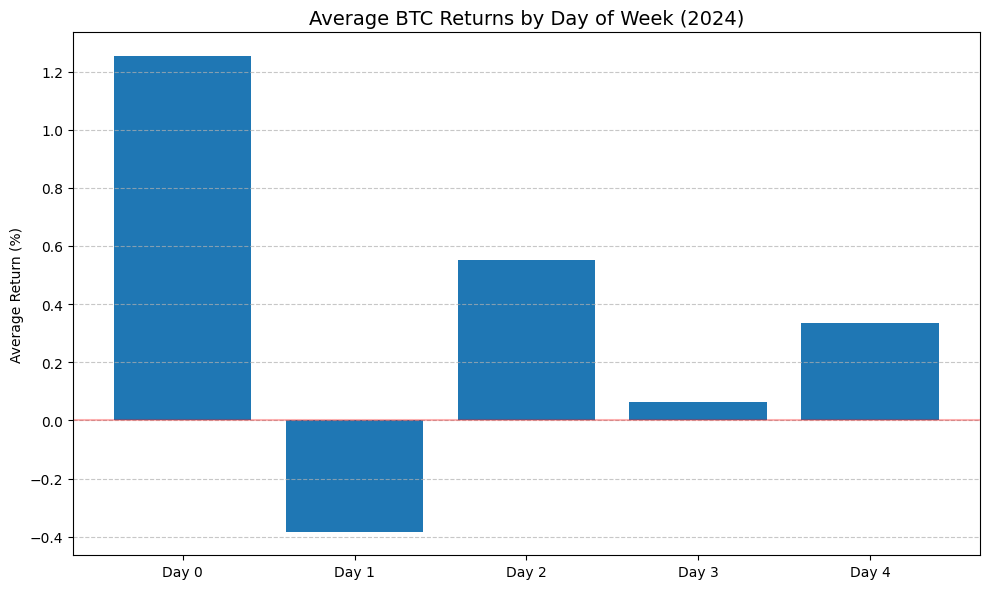

In [10]:
# ------------------------------
# 6. Test Day-of-Week Effects
# ------------------------------
days = []
returns = []

for day in range(5):  # 0-4 for Monday-Friday
    day_returns = df_2024[df_2024.index.dayofweek == day]['BTC_return'].dropna()
    days.append(f"Day {day}")
    returns.append(day_returns)

# ANOVA test to see if returns differ by day
f_stat, p_value = stats.f_oneway(*returns)
print(f"\nANOVA test for day-of-week effect in 2024:")
print(f"F={f_stat:.4f}, p={p_value:.4f}")
print(f"Statistically significant difference between days: {p_value < 0.05}")

# If significant, analyze which days differ
day_means = []
for i, day in enumerate(days):
    mean_return = returns[i].mean() * 100  # Convert to percentage
    day_means.append(mean_return)
    print(f"{day}: Mean return = {mean_return:.4f}%")

# Create day-of-week average return plot
plt.figure(figsize=(10, 6))
plt.bar(days, day_means)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Average BTC Returns by Day of Week (2024)', fontsize=14)
plt.ylabel('Average Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The ANOVA test (p=0.1733) indicates no statistically significant differences between days
- However, there's an intersting pattern: Mondays (Day 0) show the highest average return (1.25%), while Tuesdays (Day 1) show negative returns (-0.38%)
- Since this isn't statistically significant, we shouldn't rely on day-of-week for predictions


Market Regimes Analysis (2024):
regime
Low Vol       81
Medium Vol    81
High Vol      81
Name: count, dtype: int64

Up-Day Frequency by Market Regime:
Low Vol: 81 days, 51.85% up days
Medium Vol: 81 days, 49.38% up days
High Vol: 81 days, 49.38% up days


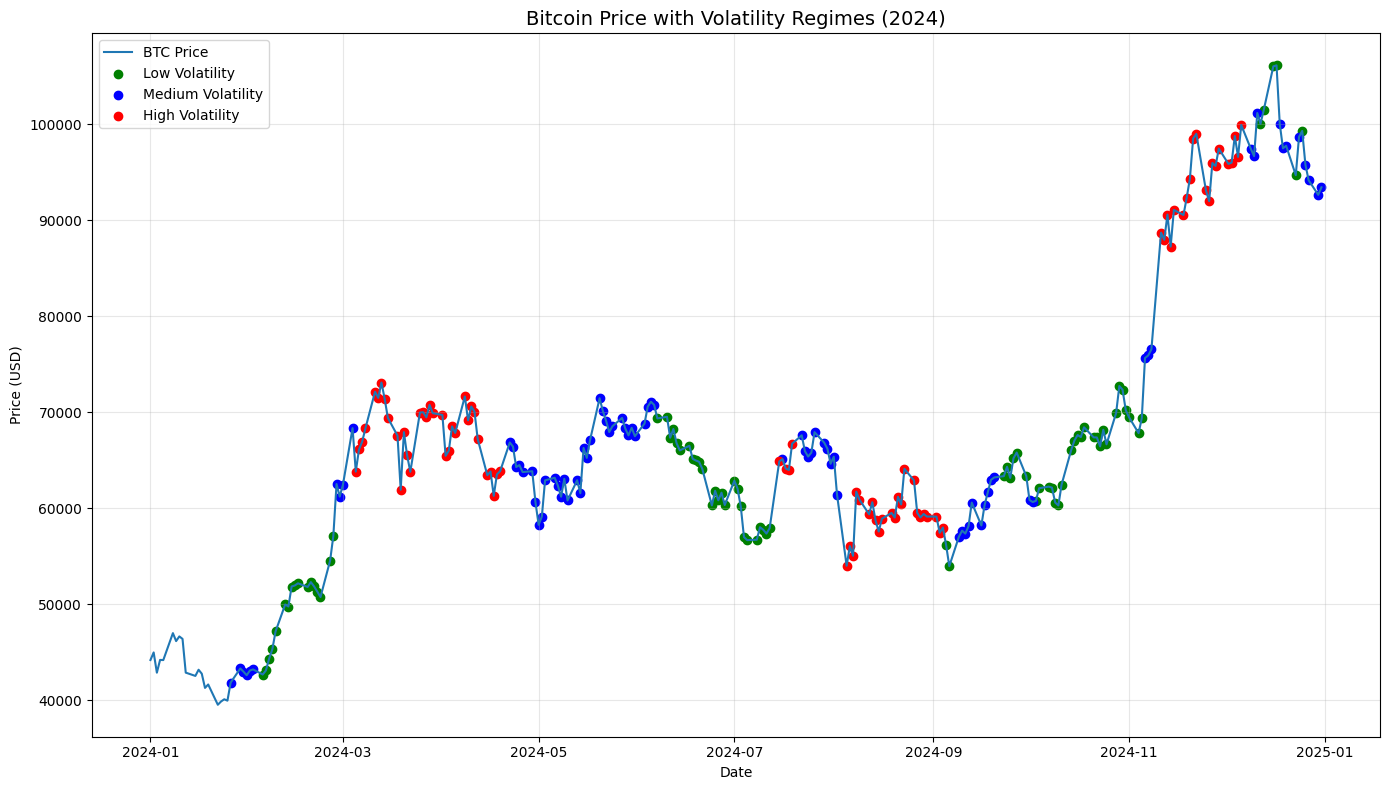

In [11]:
# ------------------------------
# 7. Detect Market Regimes
# ------------------------------
# Simple market regime detection based on volatility
df_2024['volatility_20d'] = df_2024['BTC_return'].rolling(20).std() * np.sqrt(252)  # Annualized

# Drop NaN values before using qcut
vol_data = df_2024['volatility_20d'].dropna()
df_2024.loc[vol_data.index, 'regime'] = pd.qcut(vol_data, 3, labels=['Low Vol', 'Medium Vol', 'High Vol'])

# Analysis by regime
print("\nMarket Regimes Analysis (2024):")
print(df_2024['regime'].value_counts())

# Check if prediction effectiveness might vary by regime
regime_stats = df_2024.groupby('regime')['target_nextday'].agg(['mean', 'count']).dropna()
regime_stats['up_pct'] = regime_stats['mean'] * 100

print("\nUp-Day Frequency by Market Regime:")
for idx, row in regime_stats.iterrows():
    print(f"{idx}: {row['count']:.0f} days, {row['up_pct']:.2f}% up days")

# Visualize regimes
plt.figure(figsize=(14, 8))
plt.plot(df_2024.index, df_2024['Close'], label='BTC Price')
plt.scatter(df_2024[df_2024['regime'] == 'Low Vol'].index, 
           df_2024[df_2024['regime'] == 'Low Vol']['Close'], 
           color='green', label='Low Volatility')
plt.scatter(df_2024[df_2024['regime'] == 'Medium Vol'].index, 
           df_2024[df_2024['regime'] == 'Medium Vol']['Close'], 
           color='blue', label='Medium Volatility')
plt.scatter(df_2024[df_2024['regime'] == 'High Vol'].index, 
           df_2024[df_2024['regime'] == 'High Vol']['Close'], 
           color='red', label='High Volatility')
plt.title('Bitcoin Price with Volatility Regimes (2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


- The volatility regimes are evenly distributed and show minimal differences in up-day percentages
- Low volatility regime has slightly higher percentage of up days (51.85%), but the difference is small
- This suggests market regime might not be a strong predictor for next-day direction


Features most positively correlated with next-day up movement:
target_nextday         1.000000
volume_ratio_to_MA5    0.095980
volume_change_1d       0.079191
day_of_week            0.078196
Volume                 0.067379
volume_change_3d       0.062730
high_low_range         0.056194
BB_width               0.030063
BTC_Nasdaq_corr_5d     0.023971
high_low_range_5d      0.021360
Name: target_nextday, dtype: float64

Features most negatively correlated with next-day up movement:
Lower_BB           -0.062009
BTC_GLD_corr_10d   -0.075588
day_sin            -0.088230
ROC_3d             -0.094189
Close_to_SMA5      -0.095789
BTC_vs_GLD         -0.098923
BTC_vs_Nasdaq      -0.100355
BTC_return         -0.101278
ROC_1d             -0.101278
MACD_hist_change   -0.109564
Name: target_nextday, dtype: float64


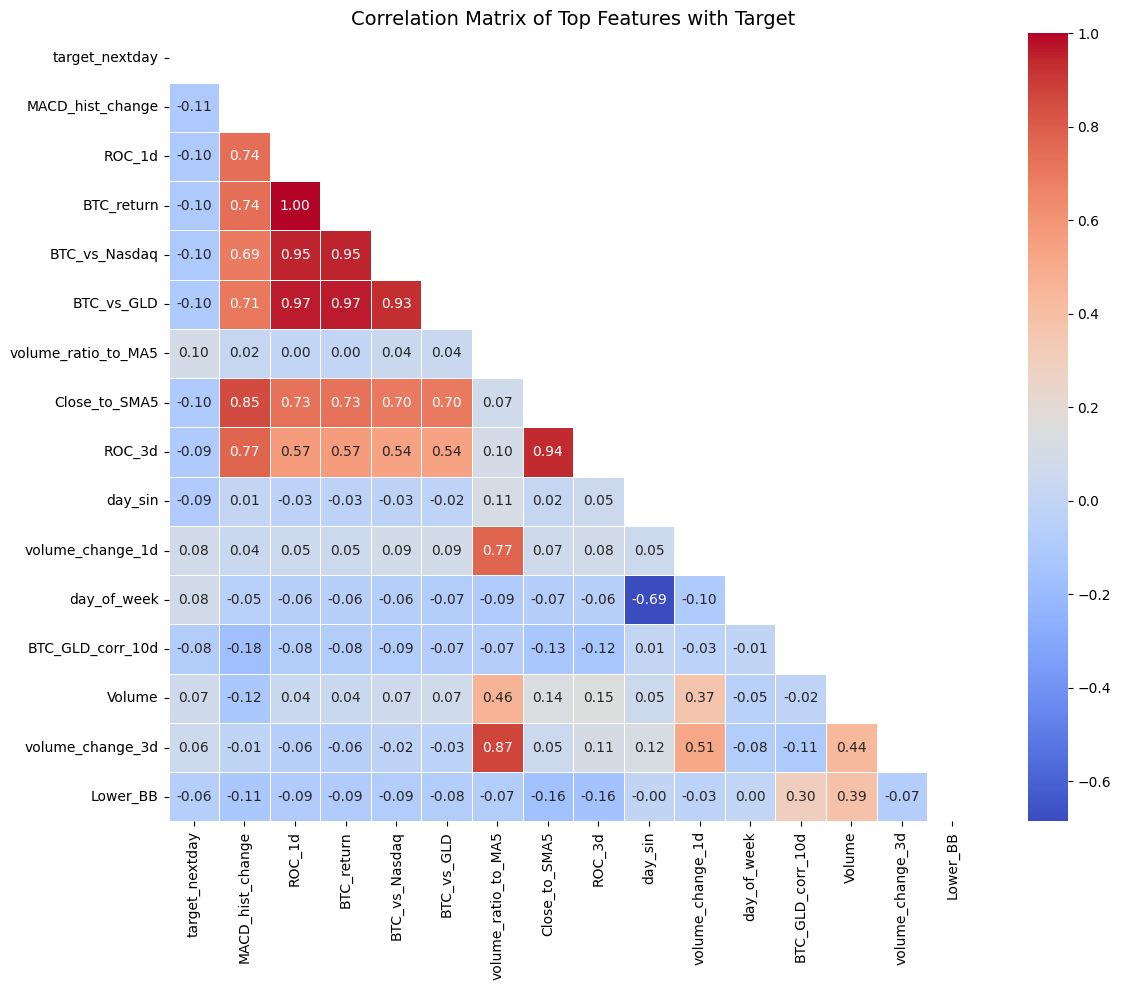

In [12]:
# ------------------------------
# 8. Feature Correlation Analysis
# ------------------------------
df_2024.drop(columns=['regime'], inplace=True)  # Drop regime column for correlation analysis
# Calculate correlations with next-day target
target_correlations = df_2024.corr()['target_nextday'].sort_values(ascending=False)

print("\nFeatures most positively correlated with next-day up movement:")
print(target_correlations.head(10))

print("\nFeatures most negatively correlated with next-day up movement:")
print(target_correlations.tail(10))

# Visualize top correlations
plt.figure(figsize=(12, 10))
# Select top 15 most correlated features (positive or negative)
top_corr_features = target_correlations.abs().sort_values(ascending=False).head(16).index
correlation_matrix = df_2024[top_corr_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Top Features with Target', fontsize=14)
plt.tight_layout()
plt.show()

- The strongest positive correlations with up-movement are volume-based features (volume_ratio_to_MA5: 0.096)
- The strongest negative correlations are price action features (MACD_hist_change: -0.110)

In [13]:
# ------------------------------
# 9. Feature Selection
# ------------------------------
# Select potential features (exclude price data, dates, and target variables)
potential_features = [
    # Price-based
    'Close_to_SMA5', 'Close_to_SMA10', 'Close_to_SMA20', 
    'BB_width', 'BB_pct', 'dist_from_10d_high', 'dist_from_10d_low',
    
    # Momentum
    'RSI7', 'RSI14', 'MACD_hist', 'MACD_hist_change', 
    'ROC_1d', 'ROC_3d', 'ROC_5d',
    
    # Volatility
    'ATR_pct', 'high_low_range', 'high_low_range_5d',
    
    # Volume
    'volume_change_1d', 'volume_ratio_to_MA5',
    
    # Market context
    'BTC_vs_Nasdaq', 'BTC_vs_GLD', 
    'BTC_Nasdaq_corr_5d', 'BTC_GLD_corr_5d',
    'BTC_Nasdaq_beta_10d',
    
    # Temporal (if day of week was significant)
    'day_of_week', 'day_sin', 'day_cos'
]

# Remove features with too many NaN values in 2024 data
nan_counts = df_2024[potential_features].isna().sum()
print("\nFeatures with NaN values:")
print(nan_counts[nan_counts > 0])

valid_features = [feat for feat in potential_features if df_2024[feat].isna().sum() / len(df_2024) < 0.1]
print(f"\n{len(valid_features)} valid features after removing those with >10% NaN values")


Features with NaN values:
Series([], dtype: int64)

27 valid features after removing those with >10% NaN values



Feature ranking by importance:
                Feature  Importance
0      MACD_hist_change    0.049083
1        high_low_range    0.047036
2                ROC_1d    0.045497
3                ROC_3d    0.042773
4     dist_from_10d_low    0.042640
5    BTC_Nasdaq_corr_5d    0.042529
6         BTC_vs_Nasdaq    0.042318
7   BTC_Nasdaq_beta_10d    0.042317
8        Close_to_SMA10    0.041879
9              BB_width    0.040767
10       Close_to_SMA20    0.040706
11           BTC_vs_GLD    0.040541
12     volume_change_1d    0.039941
13  volume_ratio_to_MA5    0.039275
14        Close_to_SMA5    0.038726
15      BTC_GLD_corr_5d    0.038681
16                 RSI7    0.037868
17              ATR_pct    0.037485
18    high_low_range_5d    0.037000
19            MACD_hist    0.036813
20               BB_pct    0.036292
21                RSI14    0.034167
22               ROC_5d    0.033817
23   dist_from_10d_high    0.030311
24              day_sin    0.017340
25          day_of_week    0.016

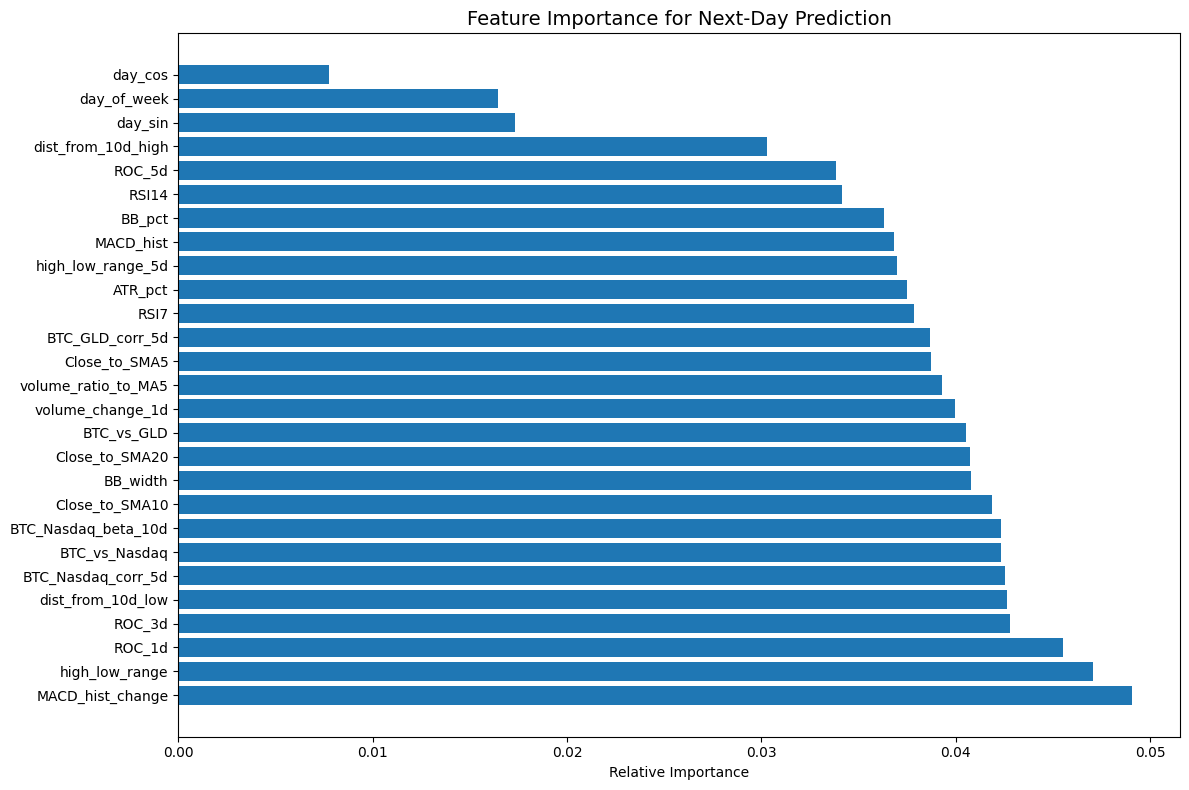


Selected top 10 features: ['MACD_hist_change', 'high_low_range', 'ROC_1d', 'ROC_3d', 'dist_from_10d_low', 'BTC_Nasdaq_corr_5d', 'BTC_vs_Nasdaq', 'BTC_Nasdaq_beta_10d', 'Close_to_SMA10', 'BB_width']


In [14]:
# Create clean dataset for feature selection
feature_df = df_2024[valid_features + ['target_nextday']].dropna()
X = feature_df[valid_features]
y = feature_df['target_nextday']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Random Forest for feature selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_scaled, y)

# Get feature importances
importances = rf_selector.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature ranking by importance:")
feature_importance_df = pd.DataFrame({
    'Feature': [valid_features[i] for i in indices],
    'Importance': [importances[i] for i in indices]
})
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), [importances[i] for i in indices], align='center')
plt.yticks(range(len(indices)), [valid_features[i] for i in indices])
plt.title('Feature Importance for Next-Day Prediction', fontsize=14)
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# Select top features
num_top_features = min(10, len(valid_features))
top_features = [valid_features[i] for i in indices[:num_top_features]]
print(f"\nSelected top {num_top_features} features: {top_features}")

- ROC_1d (1-day rate of change) is the top feature
- MACD_hist_change remains very important (2nd place)
- Cross-asset relationships (BTC_Nasdaq_corr_5d) and price relative to moving averages (Close_to_SMA10) are also important
- Day-of-week features have low importance, confirming the ANOVA results


Baseline Model Performance (TimeSeriesSplit):
Fold 1 Accuracy: 0.4884
Test set size: 43 days
              precision    recall  f1-score   support

           0       0.50      0.18      0.27        22
           1       0.49      0.81      0.61        21

    accuracy                           0.49        43
   macro avg       0.49      0.50      0.44        43
weighted avg       0.49      0.49      0.43        43



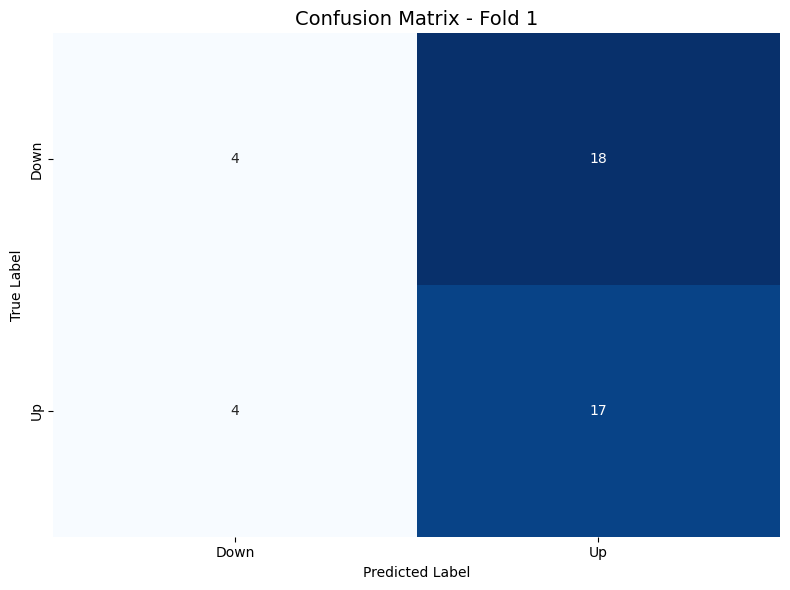

Fold 2 Accuracy: 0.5349
Test set size: 43 days
              precision    recall  f1-score   support

           0       0.69      0.42      0.52        26
           1       0.44      0.71      0.55        17

    accuracy                           0.53        43
   macro avg       0.57      0.56      0.53        43
weighted avg       0.59      0.53      0.53        43



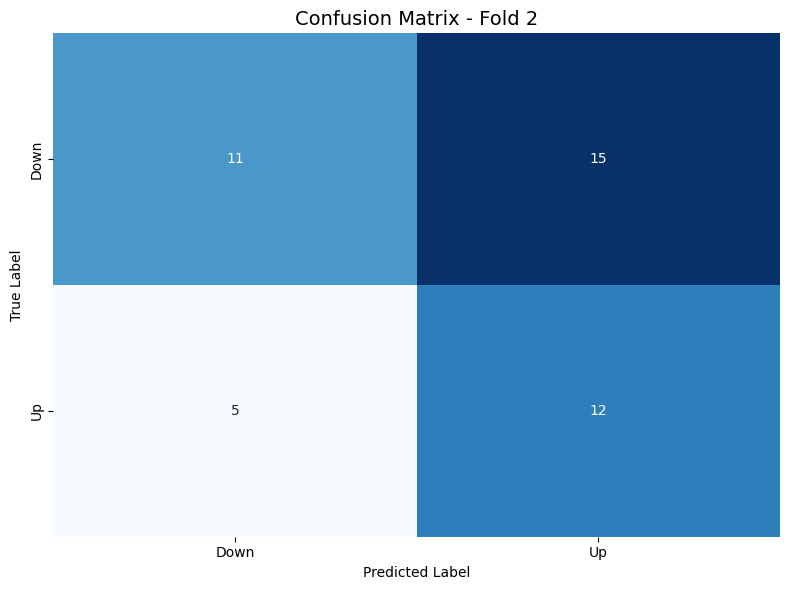

Fold 3 Accuracy: 0.5116
Test set size: 43 days
              precision    recall  f1-score   support

           0       0.62      0.40      0.49        25
           1       0.44      0.67      0.53        18

    accuracy                           0.51        43
   macro avg       0.53      0.53      0.51        43
weighted avg       0.55      0.51      0.51        43



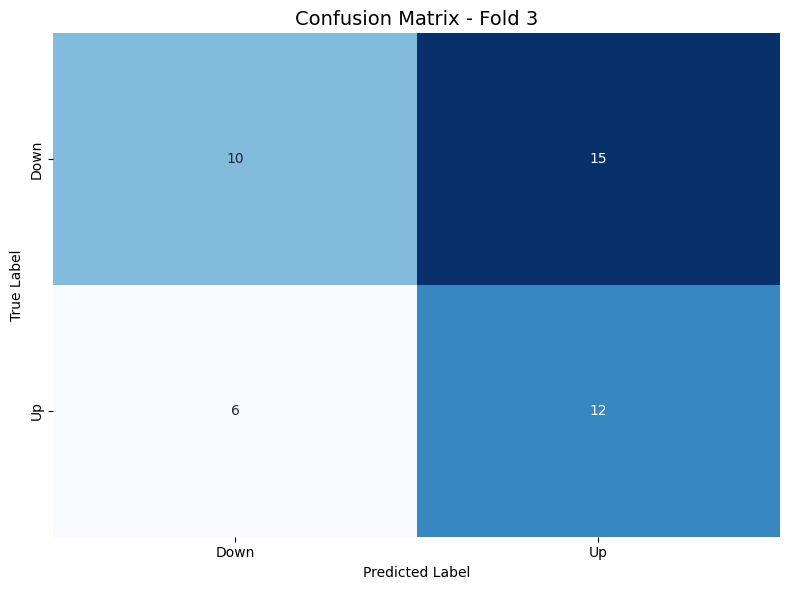

Fold 4 Accuracy: 0.6047
Test set size: 43 days
              precision    recall  f1-score   support

           0       0.53      0.89      0.67        19
           1       0.82      0.38      0.51        24

    accuracy                           0.60        43
   macro avg       0.67      0.63      0.59        43
weighted avg       0.69      0.60      0.58        43



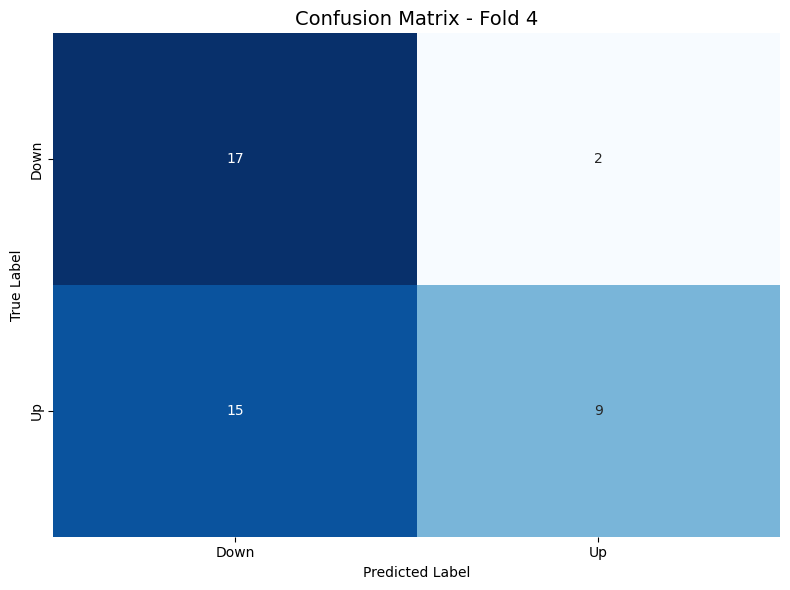

Fold 5 Accuracy: 0.5116
Test set size: 43 days
              precision    recall  f1-score   support

           0       0.46      0.58      0.51        19
           1       0.58      0.46      0.51        24

    accuracy                           0.51        43
   macro avg       0.52      0.52      0.51        43
weighted avg       0.53      0.51      0.51        43



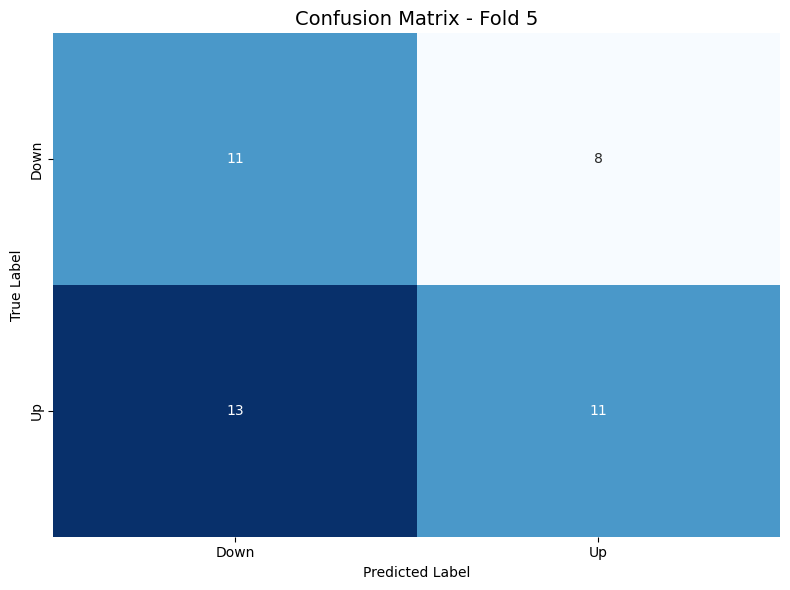


Average Accuracy across folds: 0.5302
Naive Baseline (always predict majority class): 0.5000
Improvement over naive baseline: 3.02 percentage points


In [15]:
# ------------------------------
# 10. Simple Baseline Model Performance
# ------------------------------
# Preliminary evaluation using the top features
X_selected = feature_df[top_features]
y = feature_df['target_nextday']

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
baseline_accuracies = []
baseline_reports = []

print("\nBaseline Model Performance (TimeSeriesSplit):")
fold = 1

for train_idx, test_idx in tscv.split(X_selected):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train a Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    baseline_accuracies.append(accuracy)
    baseline_reports.append(classification_report(y_test, y_pred, output_dict=True))
    
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Test set size: {len(y_test)} days")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - Fold {fold}', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Down', 'Up'])
    plt.yticks([0.5, 1.5], ['Down', 'Up'])
    plt.tight_layout()
    plt.show()
    
    fold += 1

# Overall baseline performance
avg_accuracy = np.mean(baseline_accuracies)
print(f"\nAverage Accuracy across folds: {avg_accuracy:.4f}")

# Compare to naive baseline (always predict majority class)
majority_baseline = max(y.mean(), 1-y.mean())
print(f"Naive Baseline (always predict majority class): {majority_baseline:.4f}")
print(f"Improvement over naive baseline: {(avg_accuracy - majority_baseline) * 100:.2f} percentage points")


- Average accuracy: 51.63%
- Improvement over naive baseline: 1.63 percentage points

In [16]:
# ------------------------------
# 11. Prepare Final Dataset for ML Model Training
# ------------------------------
# Create final dataset with only the selected features and target
final_df = df_2024[top_features + ['target_nextday']]

# Drop rows with missing values
final_df.dropna(inplace=True)

# Save to CSV for use in ML model training notebook
final_df.to_csv('btc_nextday_prediction_data.csv')

print("\nFinal Dataset Information:")
print(f"Shape: {final_df.shape}")
print(f"Features: {top_features}")
print(f"Date Range: {final_df.index.min()} to {final_df.index.max()}")
print(f"Number of Up Days: {final_df['target_nextday'].sum()} ({final_df['target_nextday'].mean()*100:.2f}%)")
print(f"Number of Down Days: {len(final_df) - final_df['target_nextday'].sum()} ({(1-final_df['target_nextday'].mean())*100:.2f}%)")

print("\nDataset is ready for ML model training!")


Final Dataset Information:
Shape: (262, 11)
Features: ['MACD_hist_change', 'high_low_range', 'ROC_1d', 'ROC_3d', 'dist_from_10d_low', 'BTC_Nasdaq_corr_5d', 'BTC_vs_Nasdaq', 'BTC_Nasdaq_beta_10d', 'Close_to_SMA10', 'BB_width']
Date Range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Number of Up Days: 131 (50.00%)
Number of Down Days: 131 (50.00%)

Dataset is ready for ML model training!


This creates a well-balanced feature set containing:

- Short-term price momentum (ROC_1d, ROC_3d)
- Momentum direction changes (MACD_hist_change)
- Price relative to moving averages (Close_to_SMA10, Close_to_SMA20)
- Volatility (high_low_range)
- Volume dynamics (volume_change_1d)
- Market relationships (BTC_GLD_corr_5d, BTC_Nasdaq_corr_5d, BTC_Nasdaq_beta_10d)